# **JuliaPanel**

In [1]:
include("./aeroModules.jl")
using .panelSolver
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

true

## Fundamental Solutions

In [2]:
x_domain, y_domain = (-2, 2), (-1, 1)
source_strength = 1.0
sink_strength = -1.5
kappa = 1.0
x_source, y_source = 0.0, 0.0
x_sink, y_sink = 1.0, 0.0
uniform_mag = 1.0
uniform_ang = 0.0
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size)
R = sqrt(kappa/(2π*uniform_mag));

In [3]:
sourcerer = panelSolver.Source2D(source_strength, x_source, y_source)
uniformer = panelSolver.Uniform2D(uniform_mag, uniform_ang)
doublet = panelSolver.Doublet2D(kappa, x_source, y_source)
# doublet.velocity.(X, Y)
vels = [ a .+ b for (a, b) in zip(uniformer.velocity.(X, Y), doublet.velocity.(X, Y)) ]
pots = uniformer.potential.(X, Y) .+ doublet.potential.(X, Y);
streams = uniformer.stream.(X, Y) .+ doublet.stream.(X, Y);
# vels, pots = panelSolver.gridData([uniformer, doublet], zip(X,Y))
cp = panelSolver.pressureCoefficient2D(vels, uniformer.magnitude);

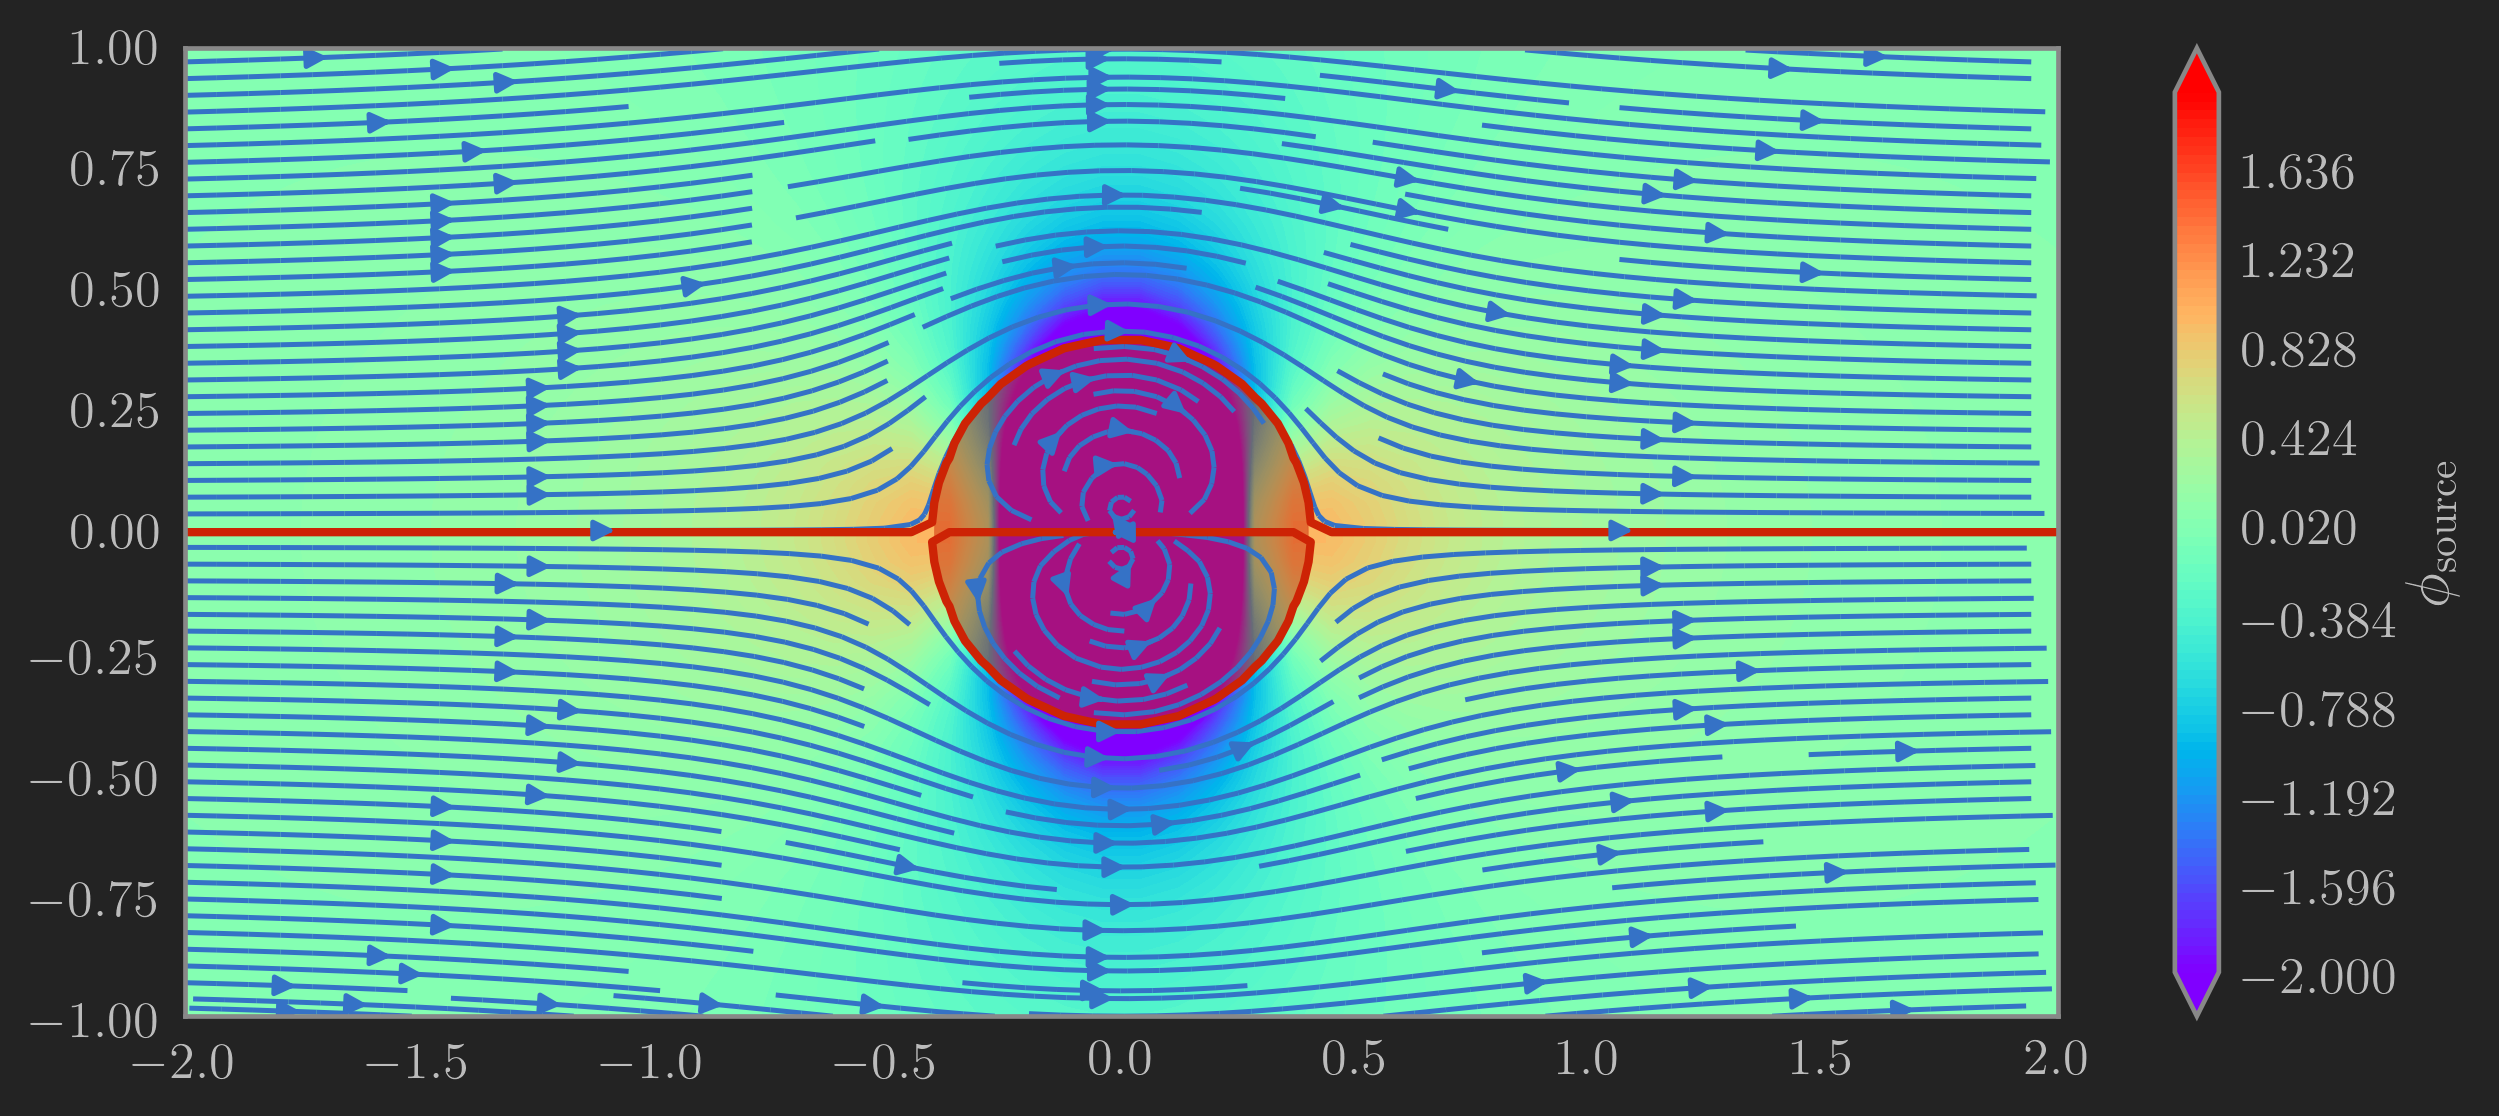

In [4]:
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig1 = figure(1, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, [ u for (u, v) in vels ], [ v for (u,v) in vels ], density=2)
contourf(X, Y, cp, levels=range(x_domain[1], stop=x_domain[end], length=100), extend="both", cmap=PyPlot.cm.rainbow)
colorbar(label="\$\\phi_{\\mathrm{source}}\$")
contour(X, Y, streams, levels=[0.], colors="#CD2305", linewidths=2, linestyles="solid")
circle = plt.Circle((0, 0), radius=R, color="#CD2305", alpha=0.5)
gca().add_patch(circle)
xlim(x_domain)
ylim(y_domain)
tight_layout();

## Panel Methods

#### Source Panels

In [5]:
x_domain, y_domain = (-3, 3), (-2, 2)
grid_size = 50
x_dom, y_dom = range(x_domain[1], stop=x_domain[2], length=grid_size), range(y_domain[1], stop=y_domain[2], length=grid_size)
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

r = 1
N_panels = 20
theta = range(0.0, stop=2π, length=N_panels + 1)
x_center, y_center = 0.0, 0.0
x_cylinder, y_cylinder = (x_center .+ r*cos.(theta), y_center .+ r*sin.(theta))
x_ends = r*cos.(theta)
y_ends = r*sin.(theta)
uniform_mag = 1.0
uniform_ang = 0.0

uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang)
source_panels = [ panelSolver.SourcePanel2D(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1]) for i in 1:N_panels ];
cylinder = panelSolver.SourcePanelSolver2D(source_panels, uniform);

In [6]:
@time strengths, vts, error = panelSolver.panelSolver2D(cylinder, uniform);
vels, pots = panelSolver.gridData(cylinder, zip(X,Y))
cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);

  6.057192 seconds (14.97 M allocations: 773.133 MiB, 8.29% gc time)


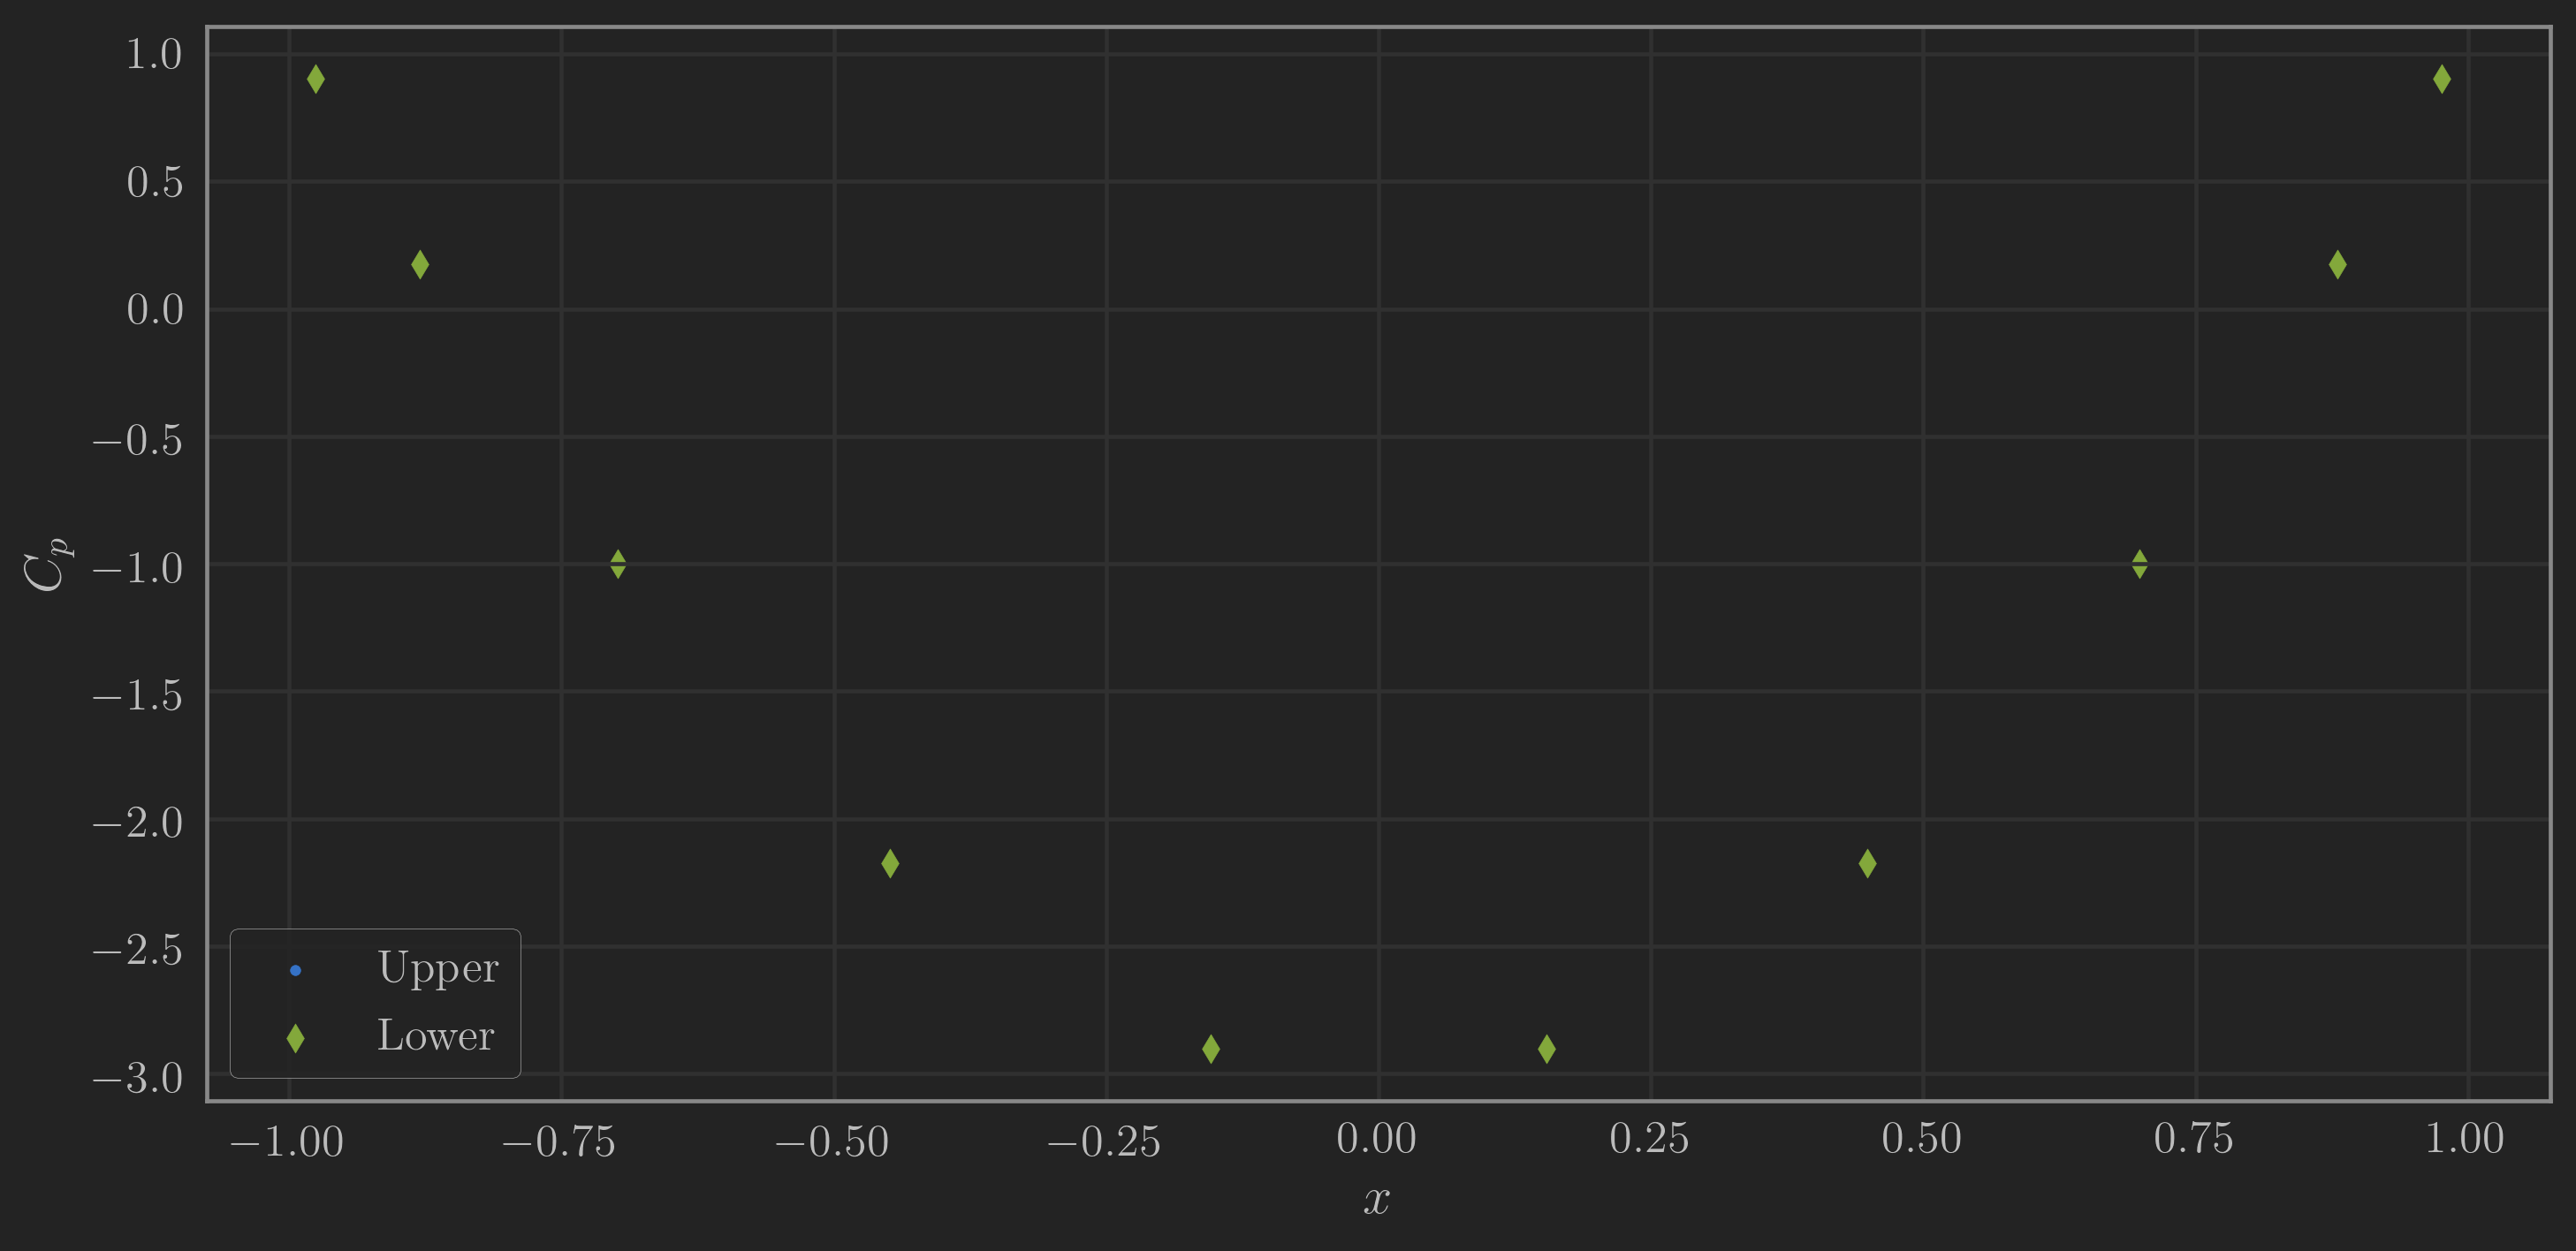

In [7]:
fig20 = figure(2, figsize=(10, 5), dpi=300)
grid()
xlabel("\$x\$")
ylabel("\$C_p\$")
# plot(x_cylinder, cp_anal, label="Analytical")
scatter([p.xc for p in source_panels if p.loc == "upper"], [p.cp for p in source_panels if p.loc == "upper" ], marker=".", label="Upper")
scatter([p.xc for p in source_panels if p.loc == "lower"], [p.cp for p in source_panels if p.loc == "lower" ], marker="d", label="Lower")
tight_layout()
legend();

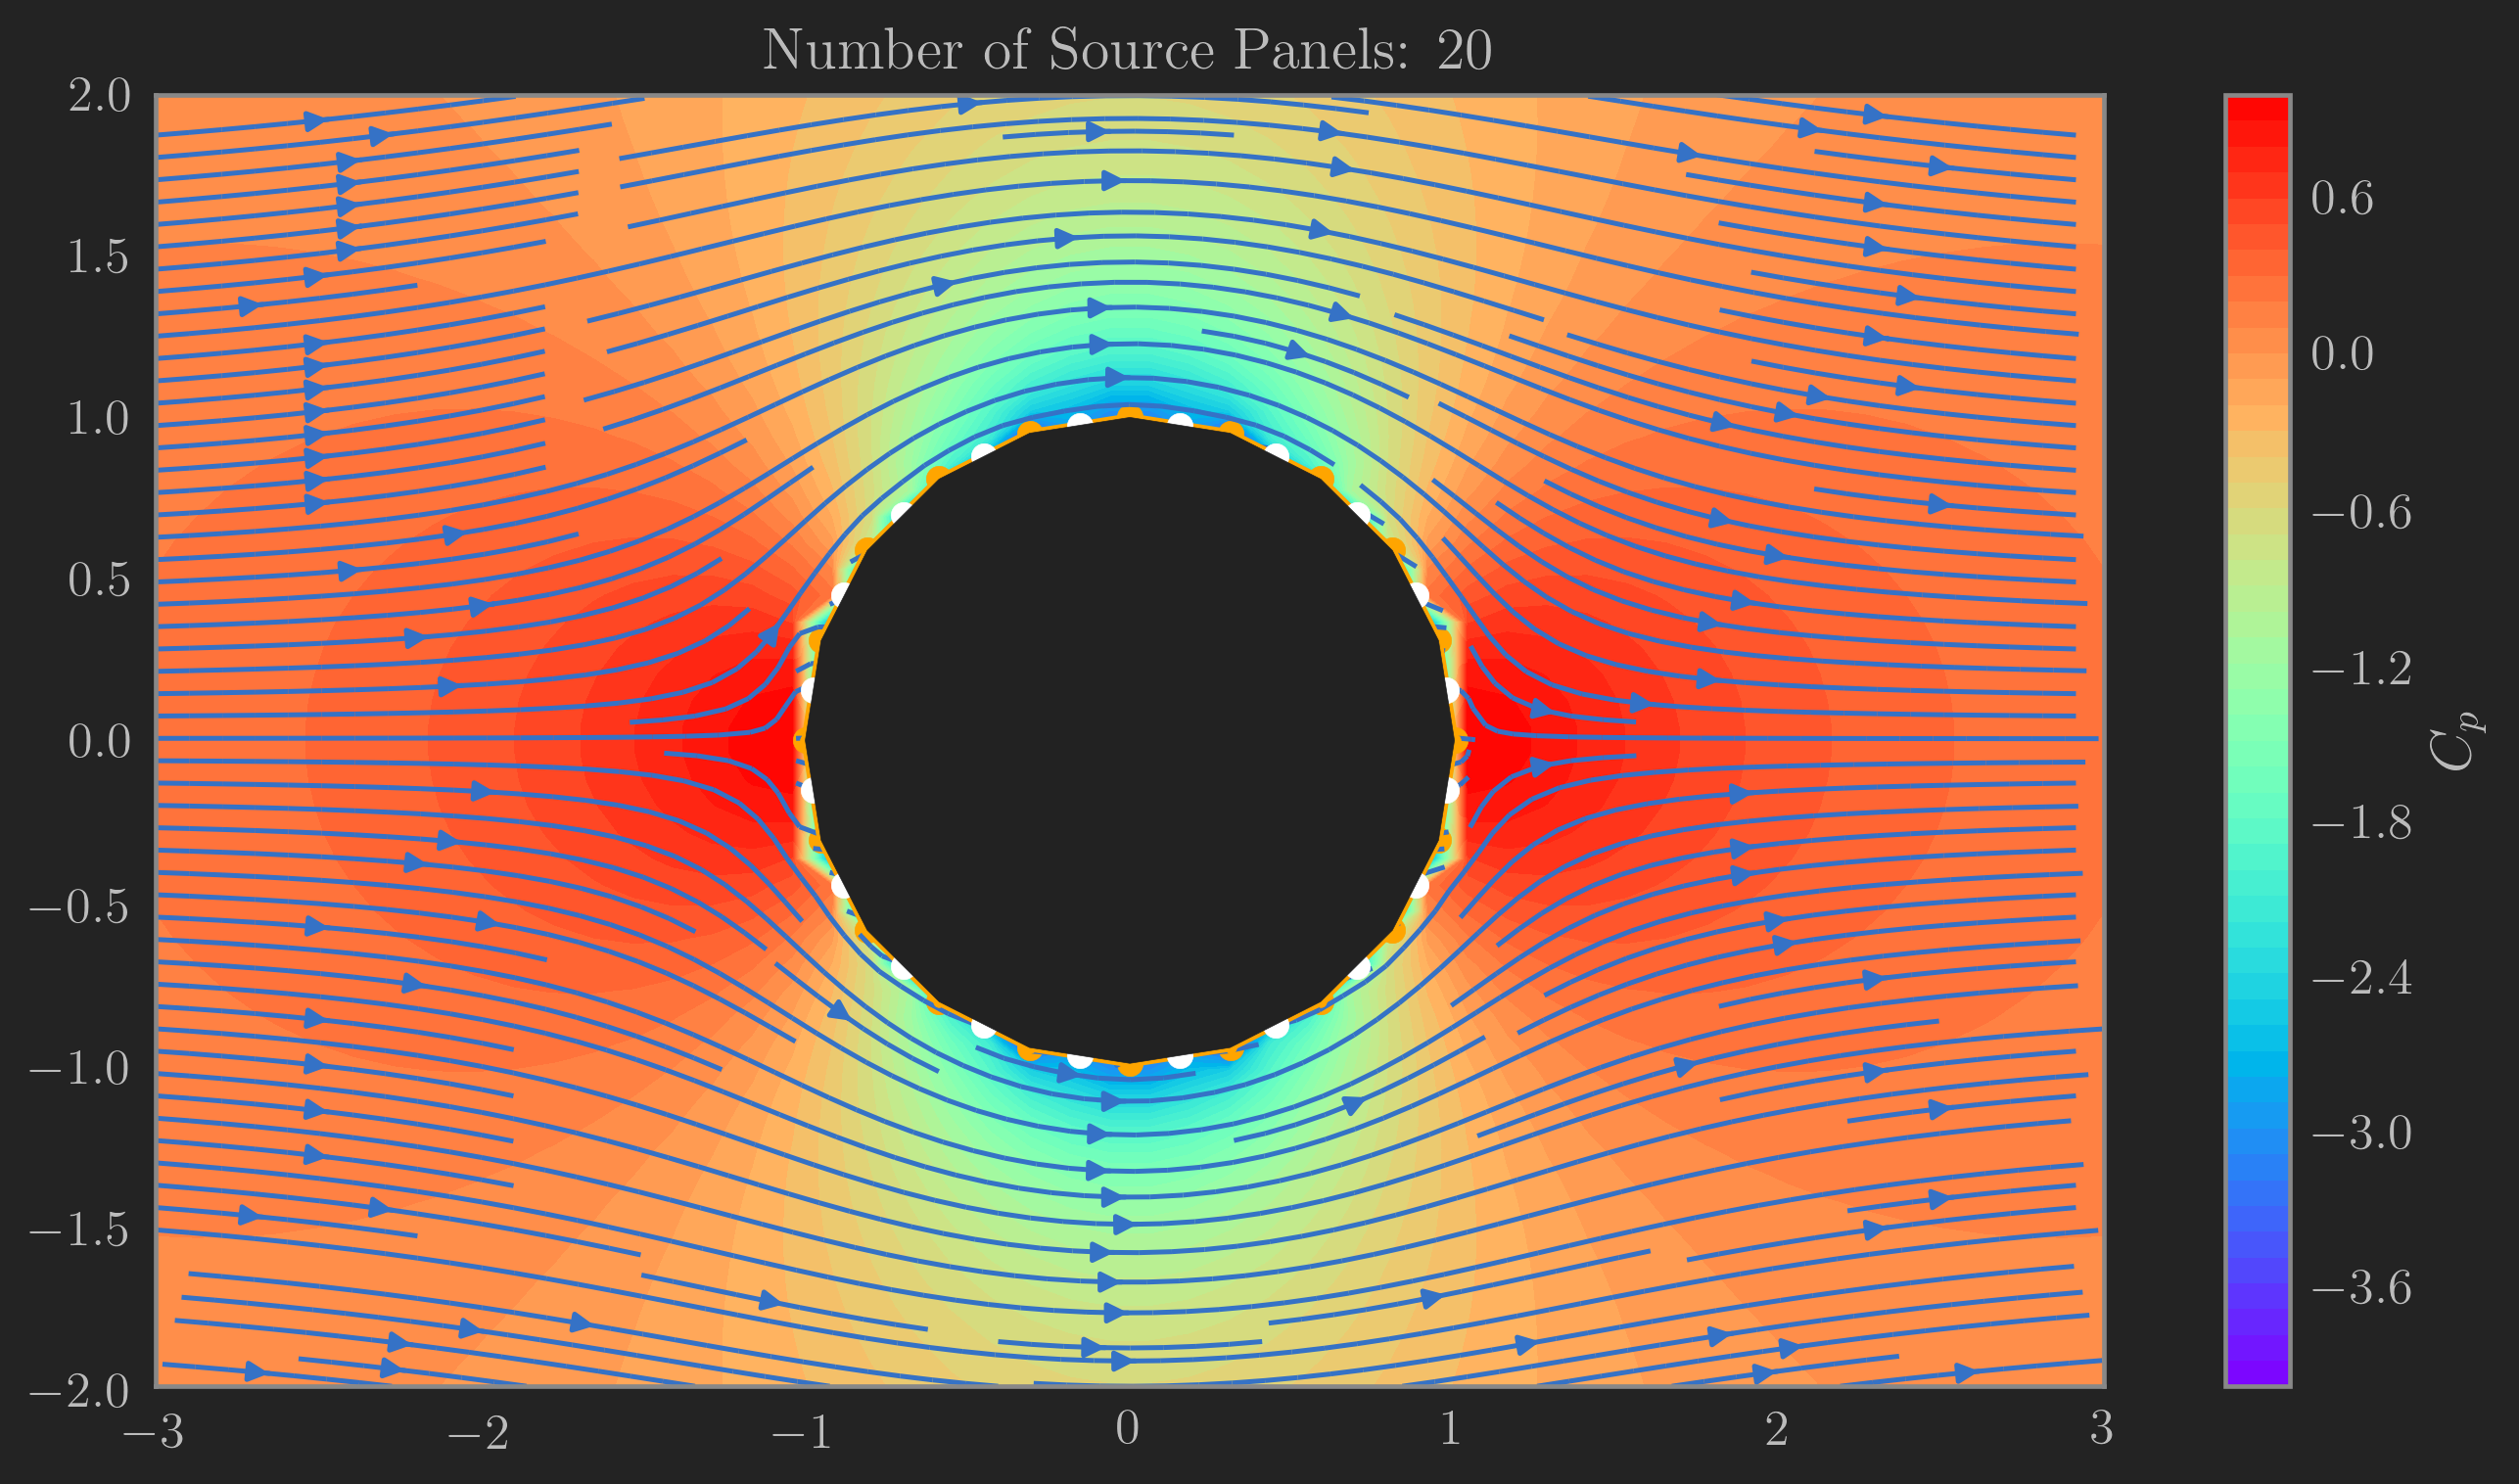

In [8]:
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig1 = figure(1, figsize=(1.15width, height), dpi=300)
streamplot(X, Y, [ u for (u,v) in vels ], [ v for (u,v) in vels ], density=2)
scatter([p.xs for p in source_panels], [p.ys for p in source_panels], marker=".", label="Endpoints", color="orange", zorder=3)
scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="black", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
plt.plot(x_cylinder, y_cylinder, label="Cylinder", color="b", linestyle="--", linewidth=1)
plot(x_ends, y_ends, label="Panels", color="orange", linestyle="-", linewidth=2)
scatter([p.xs for p in source_panels], [p.ys for p in source_panels], label="Endpoints", color="orange", s=40)
scatter([p.xc for p in source_panels], [p.yc for p in source_panels], label="Center-points", color="w", s=40, zorder=3)
fill(x_ends, y_ends, color="k", zorder=3)
title("Number of Source Panels: {$N_panels}")
tight_layout();

#### Doublet-Source Panels

In [22]:
include("./aeroModules.jl")
using .panelSolver
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

true

In [23]:
coords = open("../CAVFOIL/coordinates/ClarkY.dat") do f 
    [ Tuple(parse.(Float64,(split(line)))) for line in eachline(f) ] 
    end

N_panels = 161
# xs, ys = panelSolver.NACA4((0,0,0,9), 1.0, N_panels, true)
# coords = zip(xs, ys)
# [ print(coord) for coord in coords ]

x_domain, y_domain = (-1, 2), (-1, 1)
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

x_ends, y_ends = panelSolver.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

cosine = open("../CAVFOIL/coordinates/cosinepanels.dat", "w") do f
    [ write(f, "$x $y \n") for (x, y) in zip(x_ends, y_ends) ]
end

x_ends, y_ends = reverse(x_ends), reverse(y_ends)

uniform_mag, uniform_ang = 1.0, 0.0
panels = [ panelSolver.DoubletSourcePanel2D(xs, ys, xe, ye) for (xs, xe, ys, ye) in zip(x_ends[1:end-1], x_ends[2:end], y_ends[1:end-1], y_ends[2:end]) ];
uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang);
print(panels[1].length, " ", panels[end].length, '\n')
# [ print("Start: ", (panel.xs, panel.ys), ", End: ", (panel.xe, panel.ye), '\n', "Normal: ", panel.normal, ", Tangent: ", panel.tangent, ", Angle: ", rad2deg(panel.angle), ", Position: ", panel.loc, '\n') for panel in panels]
airfoil = panelSolver.DoubletSourcePanelSolver2D(panels, uniform, true);

0.00038248460327956096 0.00039713409845671706


In [24]:
@time strengths, vts, cl, error = panelSolver.panelSolver2D(airfoil, uniform);
vels, pots = panelSolver.gridData(airfoil, zip(X,Y));
cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);
# print([ panel.source_strength for panel in panels ])
print("Lift Coefficient: ", cl, "\n")
print("Error: ", error)

  1.162929 seconds (2.12 M allocations: 100.654 MiB, 5.15% gc time)
Lift Coefficient: (0.4103759489224664, 0.4091054852025824)
Error: 0.013308454419116083

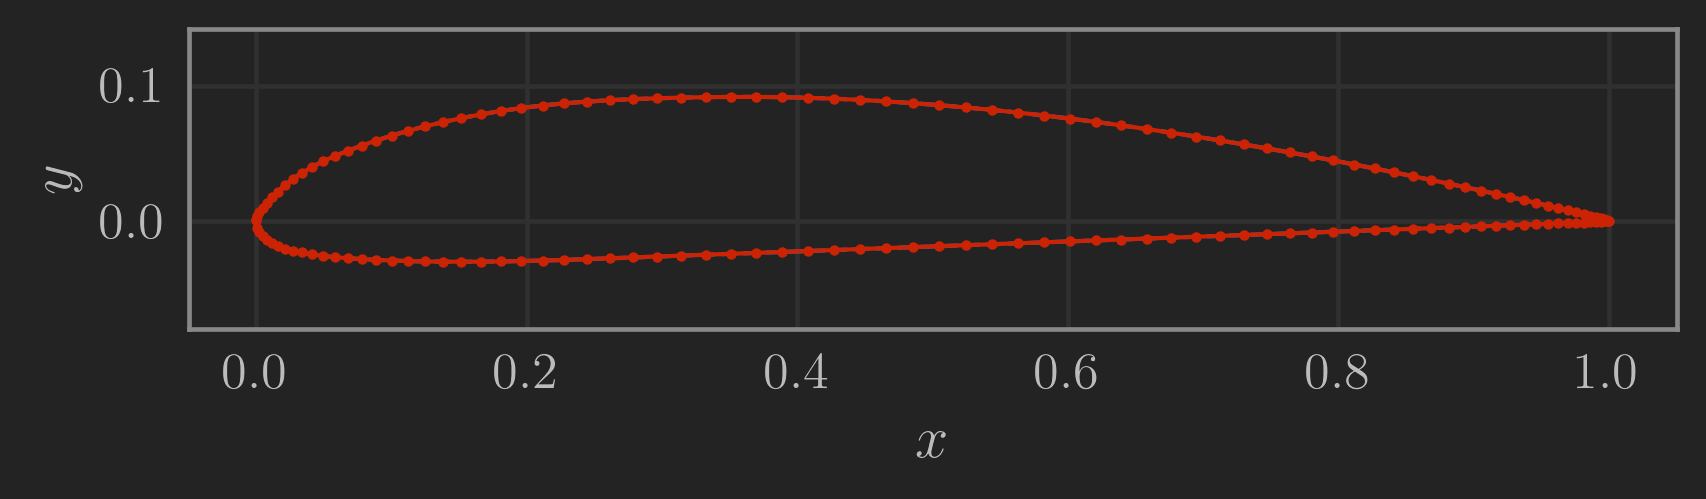

In [25]:
figure(1, dpi=300)
xlabel("\$x\$")
ylabel("\$y\$")
plot([ x for (x,y) in coords], [ y for (x,y) in coords ], linestyle="--", linewidth=1)
plot([ panel.xs for panel in panels ], [ panel.ys for panel in panels ], linestyle="-", linewidth=1, marker=".", markersize=5, color="#CD2305")
axis("scaled", adjustable="box")
# xlim(-0.02,0.02)
ylim(minimum([ y for (x,y) in coords ]) - 0.05, maximum([ y for (x,y) in coords ]) + 0.05)
grid()

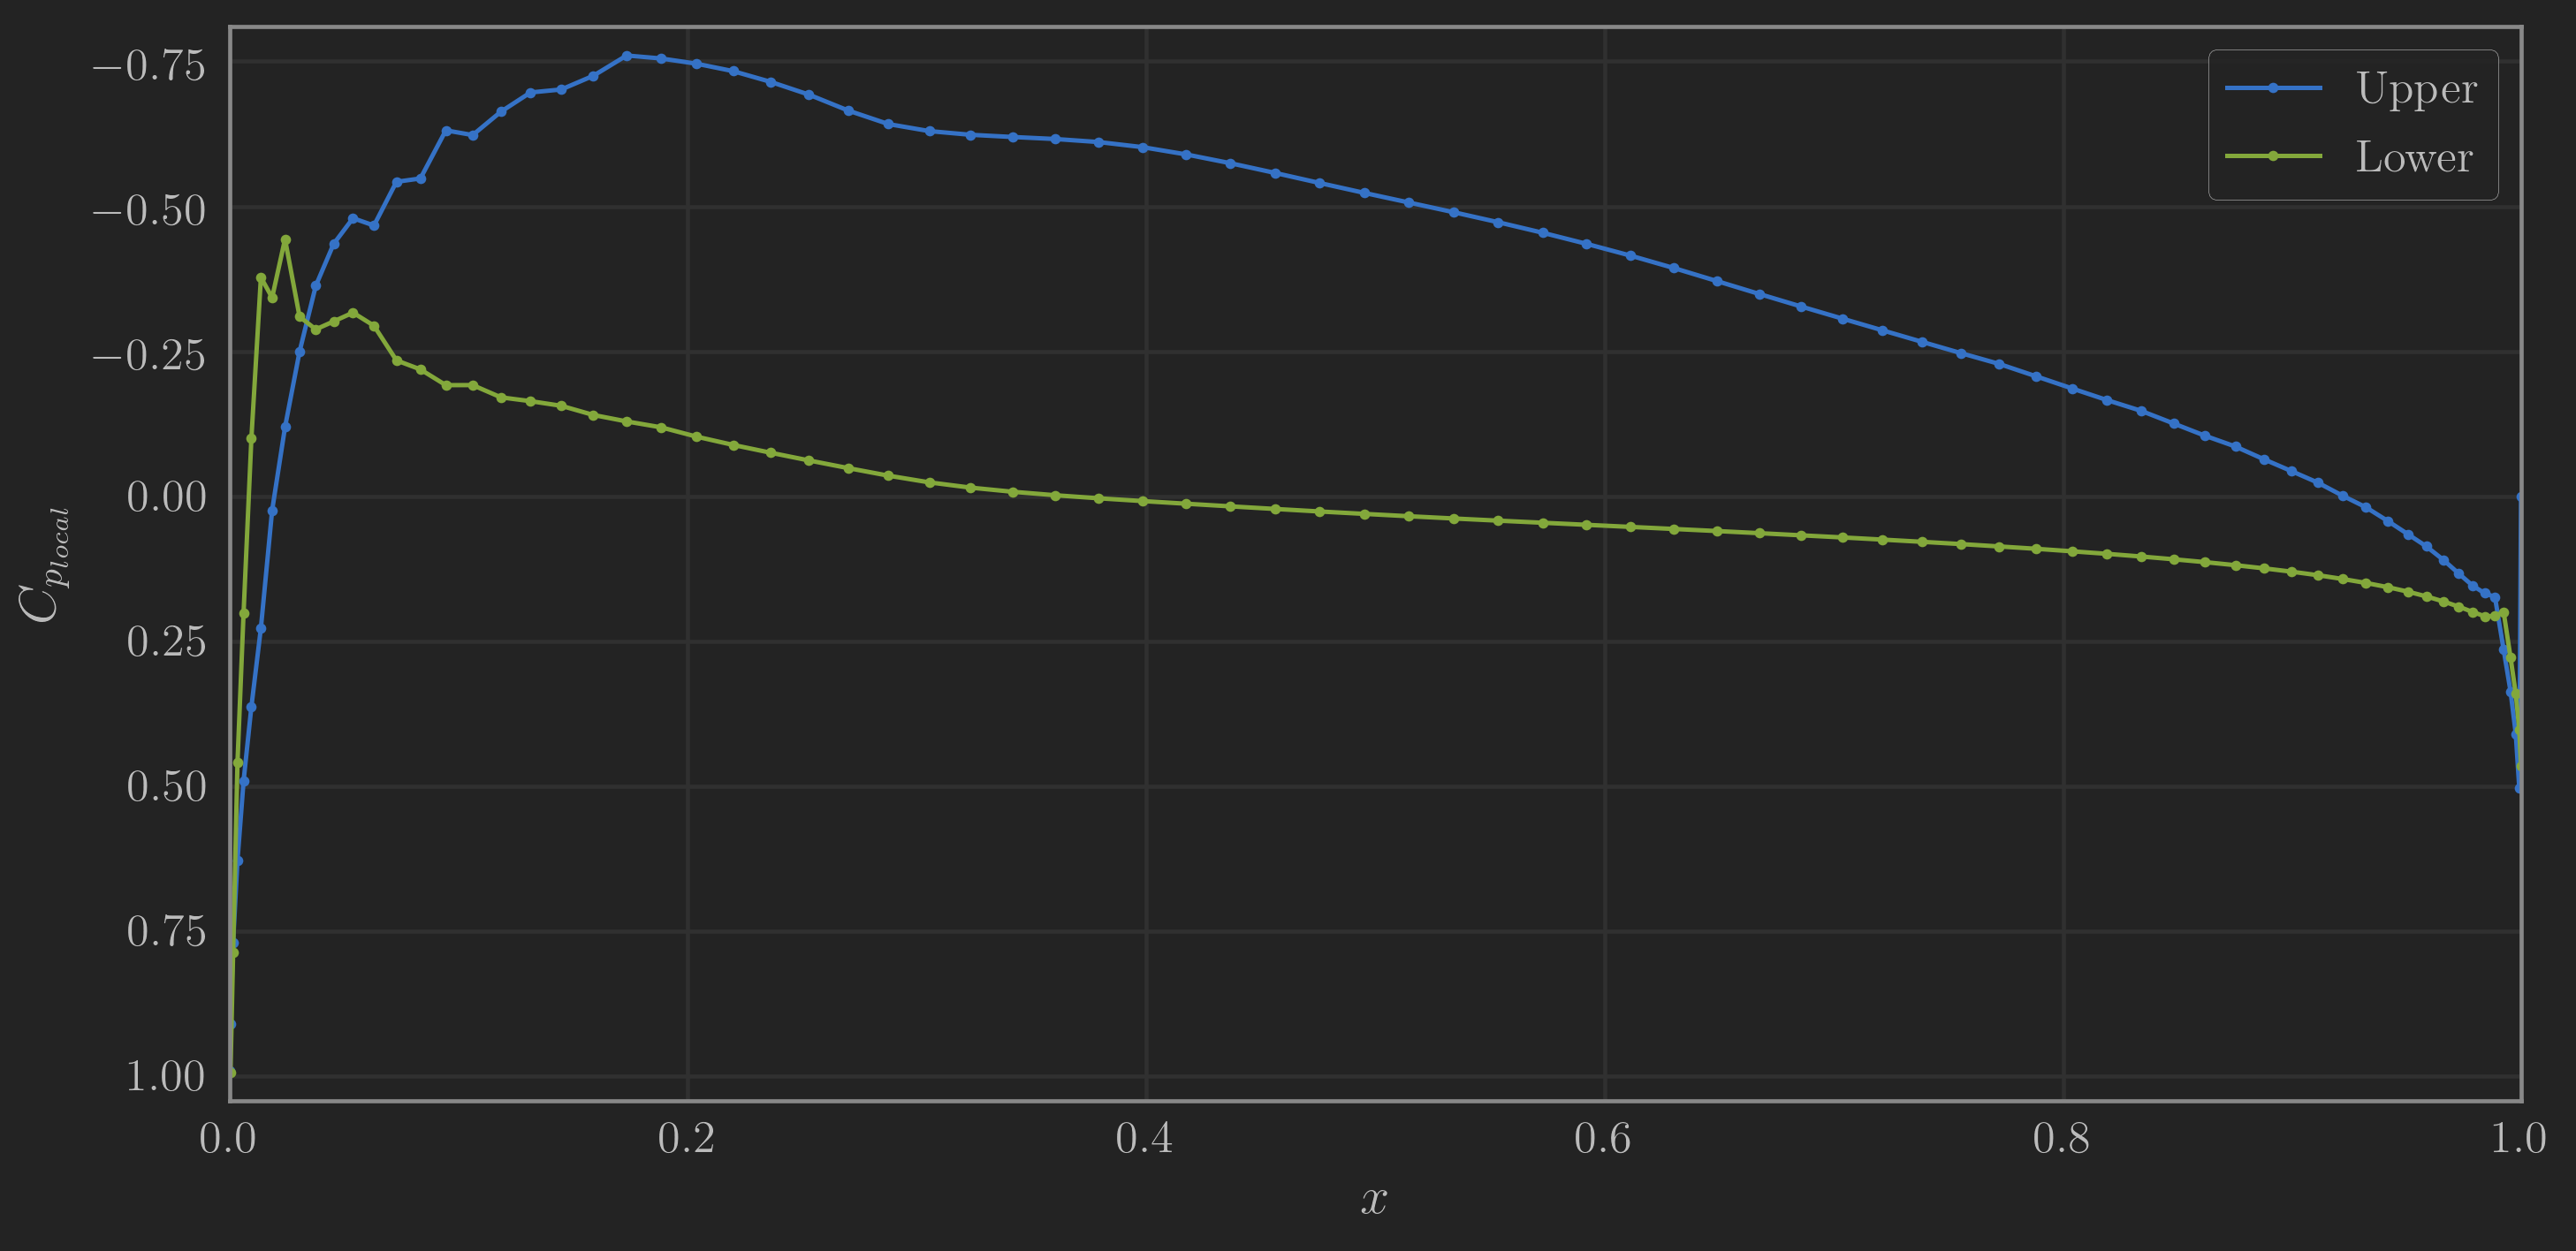

In [26]:
fig20 = figure(2, figsize=(10, 5), dpi=300)
grid()
plot([p.xc for p in panels if p.loc == "upper" ], [p.cp for p in panels if p.loc == "upper" ], marker=".", label="Upper")
plot([p.xc for p in panels if p.loc == "lower" ], [p.cp for p in panels if p.loc == "lower" ], marker=".", label="Lower")
xlabel("\$x\$")
ylabel("\$C_{p_{local}}\$")
xlim(0, 1.0)
ylim(-2,2)
ylim(maximum([p.cp for p in panels]) + 0.05, minimum([p.cp for p in panels]) - 0.05)
tight_layout()
legend();

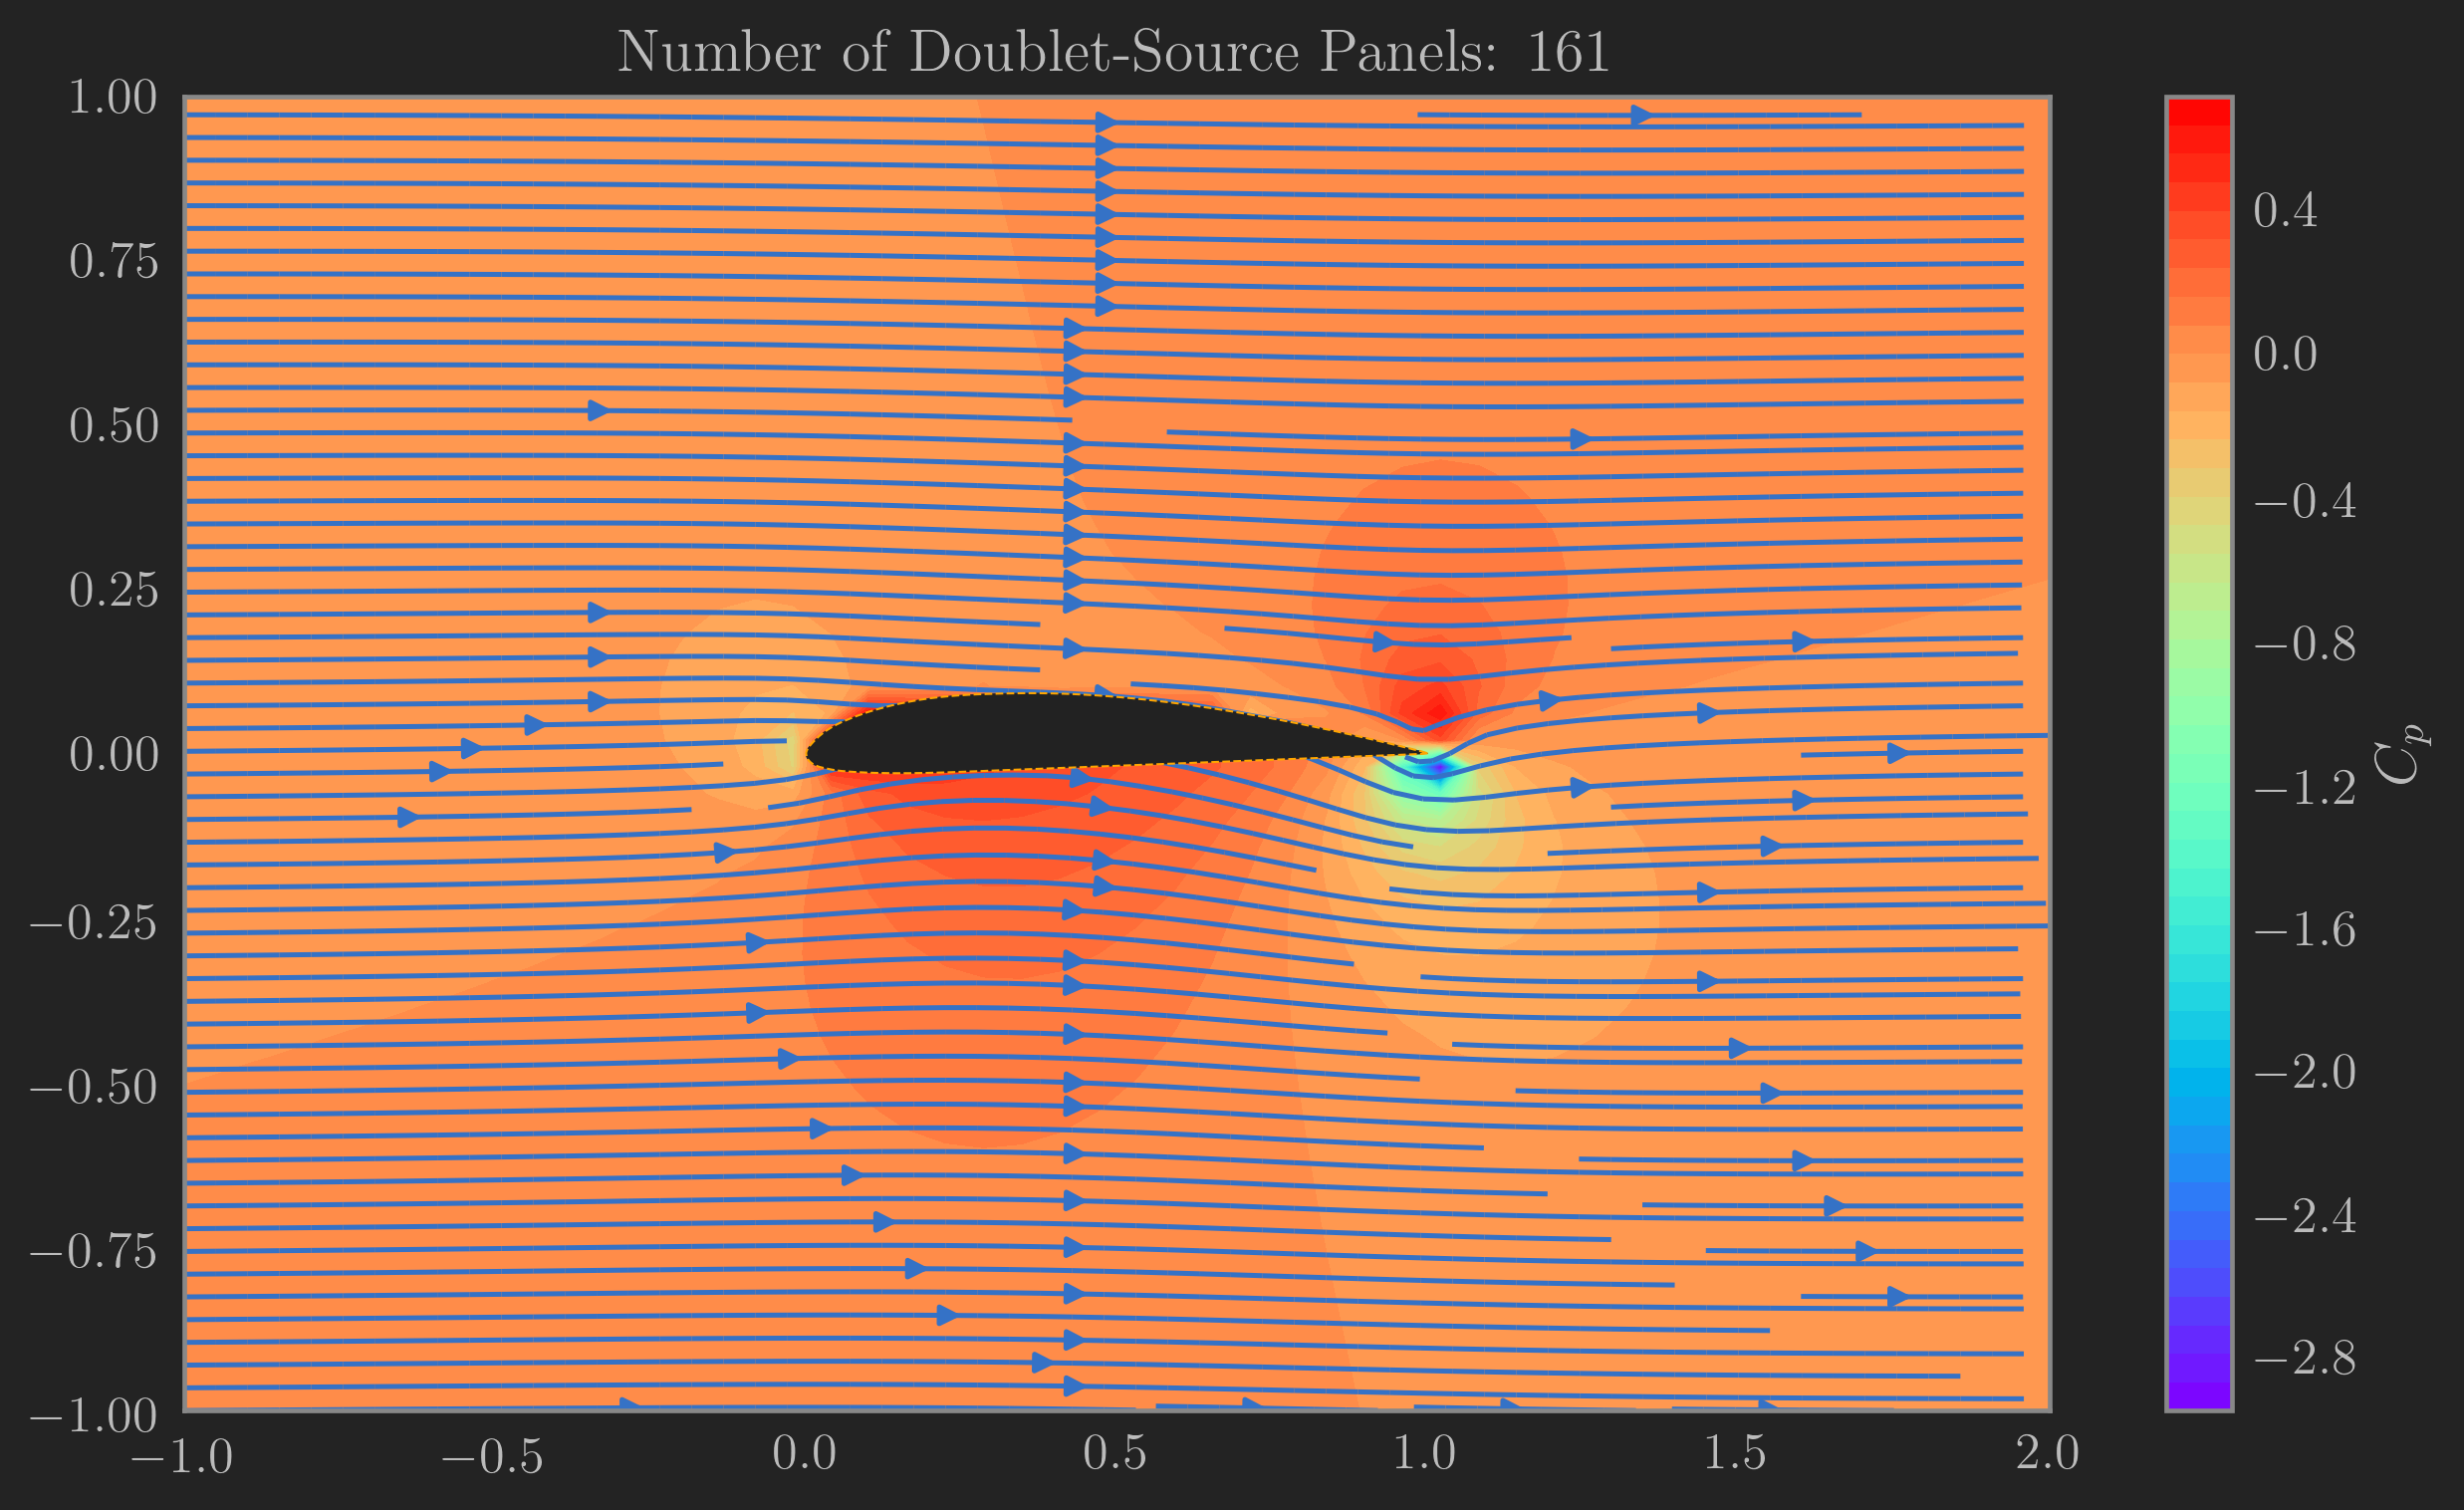

In [27]:
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig1 = figure(1, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, first.(vels), last.(vels), density=2)
# scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="white", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
fill([x for (x,y) in coords], [y for (x,y) in coords], color="k", zorder=3)
plot([p.xs for p in panels], [p.ys for p in panels], linestyle="--", linewidth=0.5, label="Endpoints", color="orange", zorder=3)
xlim(x_domain)
ylim(y_domain)
title("Number of Doublet-Source Panels: {$N_panels}")
tight_layout();